## Image Classifier using Keras

In [138]:
# Import libraries for array manipulation, data proecssing and analysis, Visualization
import os
import gc
import random

import numpy as np
import pandas as pd

import cv2

import matplotlib.pyplot as plt
#matplotlib inline


In [139]:
# Get the data ready
dataset_dir = '/Users/ravisher/Development/FatehLabs/machine-learning-projects/datasets'
model = 'dogs-vs-cats'

train_dir = os.path.join(dataset_dir, model, 'train')
test_dir = os.path.join(dataset_dir, model, 'test1')

train_dogs = [i for i in os.listdir(train_dir) if 'dog' in i]
train_cats = [i for i in os.listdir(train_dir) if 'cat' in i]

test_set = [i for i in os.listdir(test_dir)]
train_set = train_dogs[:2000] + train_cats[:2000]

random.shuffle(train_set)
del train_dogs
del train_cats

gc.collect()


172474

In [24]:
!pip install opencv-python

     |████████████████████████████████| 51.6MB 3.8MB/s eta 0:00:01    |█████▌                          | 8.8MB 5.1MB/s eta 0:00:09     |████████████████████▍           | 32.9MB 67kB/s eta 0:04:37     |██████████████████████████████▋ | 49.3MB 5.4MB/s eta 0:00:01


### Now let's see the data. we can use matplotlib.image to read the image file and matplotlib.pyplot to show the image. if the image file is .jpg make sure to install Pillow.

In [18]:
!pip install pillow

     |████████████████████████████████| 3.9MB 6.1MB/s eta 0:00:01


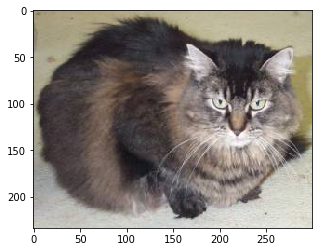

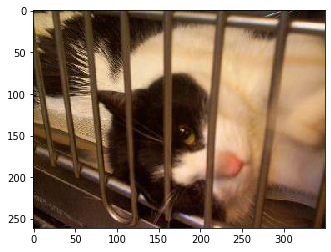

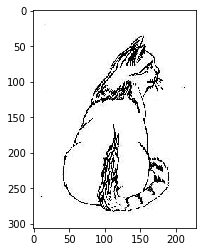

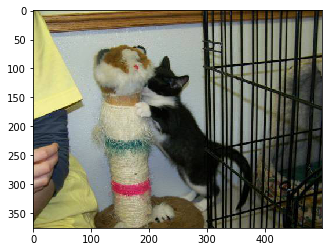

In [140]:
import matplotlib.image as mpimg
for img in train_set[:4]:
    image = mpimg.imread(train_dir + '/{0}'.format(img))
    implot = plt.imshow(image)
    plt.show()

### If the images are not of same size, that's a problem. We need to make sure that images are of same dimension for the model to process them.

In [141]:
# Set image dimensions
img_width = 150
img_height = 150
channel = 3

In [142]:
# process image
def process_image(input_dir, imglist):
    """
        Update the image to be of same dimension.
        Return two arrays, X and y which contains the Images and labels respectively.
    """
    X = []
    y = []
    for img in imglist:
        img_path = input_dir + '/{}'.format(img)
        i = cv2.imread(img_path, cv2.IMREAD_COLOR)
        cv_img = cv2.resize(i, (img_width, img_height), interpolation=cv2.INTER_CUBIC)
        X.append(cv_img)
        if 'dog' in img:
            y.append(1)
        elif 'cat' in img:
            y.append(0)
        
    return X, y


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



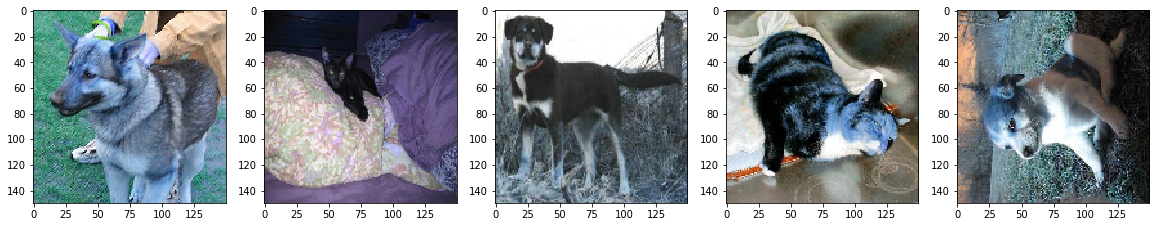

In [61]:
X, y = process_image(train_set)
print(X)
plt.figure(figsize=(20, 10))

columns = 5
for i in range(columns):
    plt.subplot(5/columns + 1, columns, i + 1)
    plt.imshow(X[i])

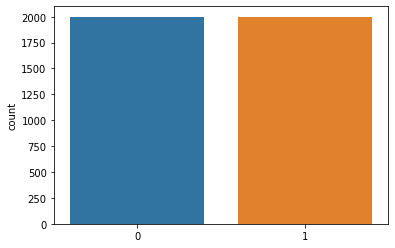

In [143]:
# Make sure we have same label count as images and equally divided
import seaborn as sns

# convert list to numpy array
X = np.array(X)
y = np.array(y)

sns.countplot(y) # count number of samples per class

In [144]:
# Understand shape of your dataset
print('Shape of trian image {}', X.shape)
print('Shape of train label {}', y.shape)

Shape of trian image {} (4000, 150, 150, 3)
Shape of train label {} (4000,)


In [145]:
# Train and validation split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.20, random_state=2)

print('Shape of train image is {}', X_train.shape)
print('Shape of train label is {}', y_train.shape)
print('Shape of validation image is {}', X_val.shape)
print('Shape of validation label is {}', y_val.shape)

Shape of train image is {} (3200, 150, 150, 3)
Shape of train label is {} (3200,)
Shape of validation image is {} (800, 150, 150, 3)
Shape of validation label is {} (800,)


### Fun times: time to build the model now.

In [148]:
### Need to import keras library
from keras import layers
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

In [149]:
model = Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [150]:
#See the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [151]:
model.compile(optimizer=optimizers.RMSprop(lr=.001), loss='binary_crossentropy', metrics=['acc'])

In [152]:
# define the generators
train_datagen = ImageDataGenerator(rescale=1/255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1/255)

In [153]:
# create the generators
batch_size = 32
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [154]:
history = model.fit_generator(train_generator,
                   steps_per_epoch=len(X_train) // batch_size,
                   epochs=8,
                   validation_data=val_generator,
                   validation_steps= len(X_val) // batch_size)

Epoch 1/8
100/100 [==============================] - 126s 1s/step - loss: 0.7128 - acc: 0.5141 - val_loss: 1.7295 - val_acc: 0.4888
Epoch 2/8
100/100 [==============================] - 118s 1s/step - loss: 0.6941 - acc: 0.5541 - val_loss: 0.7270 - val_acc: 0.5275
Epoch 3/8
100/100 [==============================] - 126s 1s/step - loss: 0.6901 - acc: 0.5553 - val_loss: 0.6568 - val_acc: 0.6338
Epoch 4/8
100/100 [==============================] - 120s 1s/step - loss: 0.6802 - acc: 0.5822 - val_loss: 0.6466 - val_acc: 0.6225
Epoch 5/8
100/100 [==============================] - 126s 1s/step - loss: 0.6682 - acc: 0.6063 - val_loss: 0.6269 - val_acc: 0.6375
Epoch 6/8
100/100 [==============================] - 113s 1s/step - loss: 0.6642 - acc: 0.6194 - val_loss: 0.6055 - val_acc: 0.6775
Epoch 7/8
100/100 [==============================] - 138s 1s/step - loss: 0.6529 - acc: 0.6256 - val_loss: 0.6253 - val_acc: 0.6587
Epoch 8/8
100/100 [==============================] - 113s 1s/step - loss: 0.

In [155]:
# Save the model
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

In [134]:
X_test, y_test = process_image(test_dir, test_set[0:10])
x = np.array(X_test)
print('x Shape: ', x.shape)
test_datagen = ImageDataGenerator(rescale=1/255)

x Shape:  (10, 150, 150, 3)


0.51892537
0.8797866
0.35850328
0.9999392
0.40401706
0.4222054
0.98917234
0.6073151
0.48080602
0.4916035


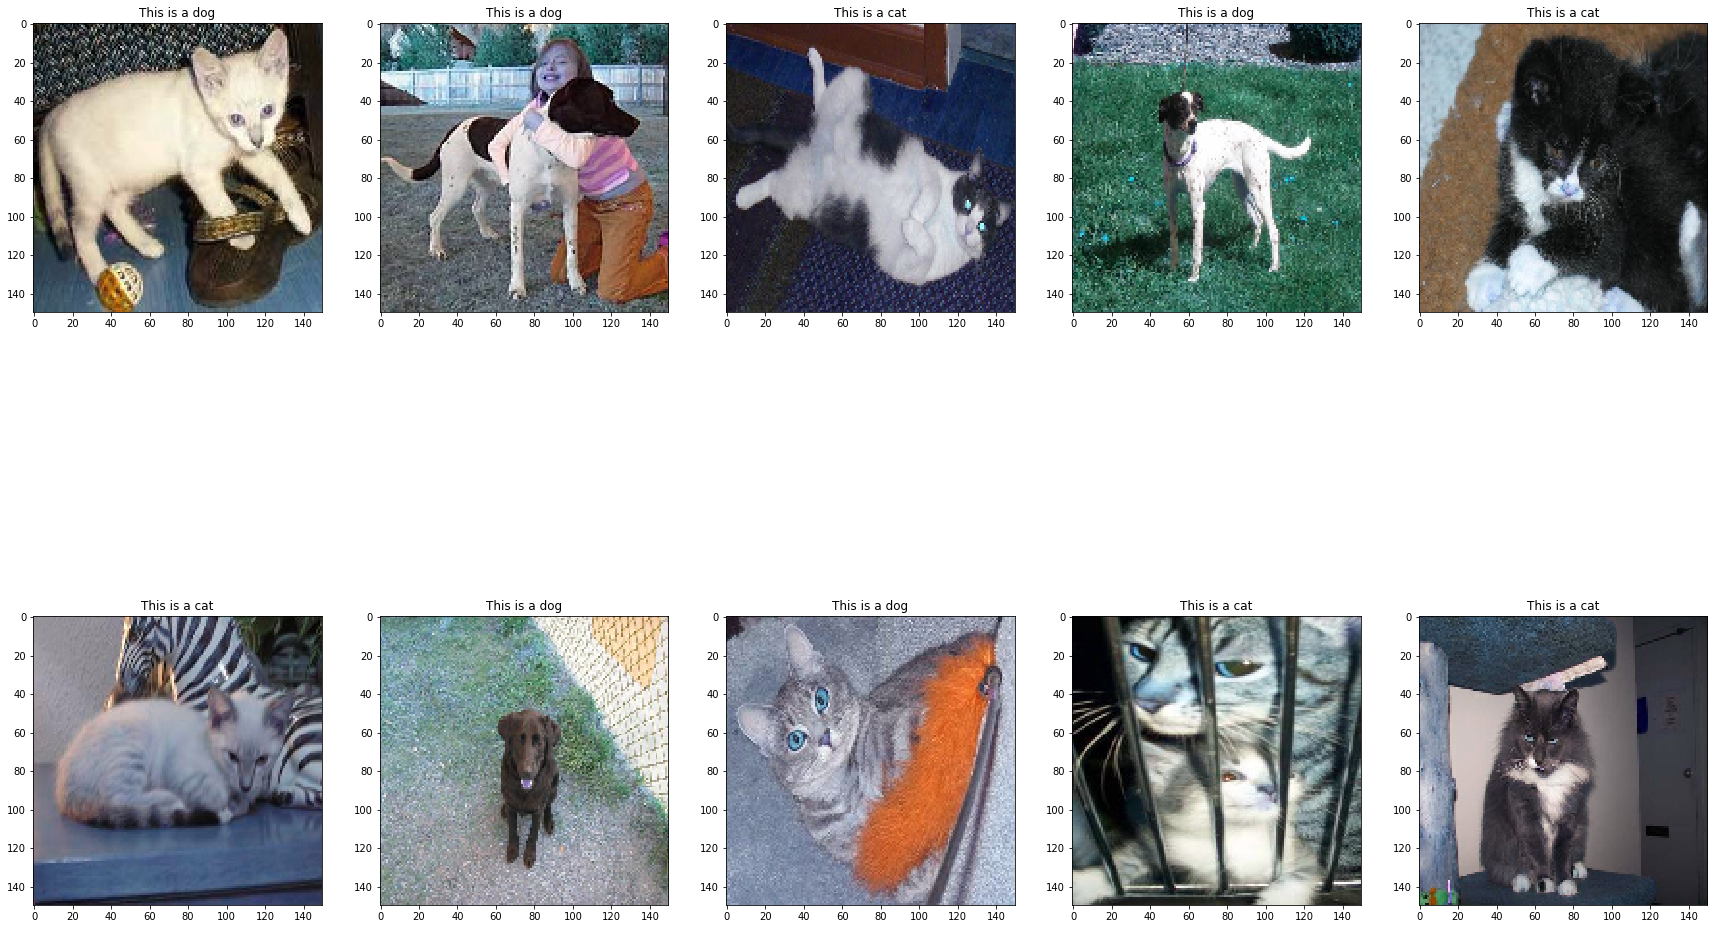

In [137]:
# Predict Phase
i = 0
text_labels = []
plt.figure(figsize=(30, 20))

for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    print(pred[0][0])
    if pred > 0.5:
        text_labels.append('dog')
    else:
        text_labels.append('cat')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('This is a ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break;
plt.show()
